# OpenRefine MCO2

This dataset mainly focuses on tides in Puerto Princesa, Palawan from 2017 to 2020. 
The information that will be included in this dataset are:
- date of record
- day of record
- sunrise time
- sunset time
- moonrise time
- moonset time
- tide height
- tide time
- tide type
- tidal coefficient
- coefficient interpretation
- red tide occurrence in Honda bay and Puerto Princesa Bay

# Import of Packages

In [68]:
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import datetime
import time as time
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calplot

import os
from IPython.display import display

# Data Collection (NO NEED TO RUN)
The sites that were scraped are as follows:
- Tide Information:
    - https://tides4fishing.com/as/philippines/puerto-princesa#_tide_table
- Moon Rise and Set
    - http://moon.5deg.com/ph/puerto-princesa/
    
Information on the red tide occurrences were obtained from the red tide bulletin of the Philippine Burueau of Fisheries and Aquatic Resources and was manually encoded into a csv file.

## Tide Information
Information about the tides were obtained from Tides4Fishing. The site's content for historical data could not be accessed through changing the URL since the site was coded in such a way that the data is being accessed through a javascript within the site. Selenium was used to scrape the historical data.

Accessing the Tides4Fishing site and checking of page content

In [4]:
URL = "https://tides4fishing.com/as/philippines/puerto-princesa#_tide_table"

#This variable holds the information requested from the URL
page = requests.get(URL)

#This variable gets the HTML code through page
soup = BeautifulSoup(page.content, 'html.parser') 

Finding and accessing the table where the desired data was scraped.

In [8]:
# From the HTML code stored in soup, we find the portion of the code with id, tabla_mareas_fondo.
# In which, we will be looking for the desired table.
tides4fishing_content = soup.find(id = 'tabla_mareas_fondo')
tides4fishing_tables = tides4fishing_content.find_all('table')

Trial of scraping of one month and temporarily placing the information obtained into a data frame.

Information can be accessed through the following indices:

|Index|Information|
|-----|-----------|
|  1  |Day of Month (1-31) and Day of Week (Sun, Mon, Tue, Wed, Thu, Fri, Sat)|
|  5  |Sunrise and Sunset Time (24-hour format)|
|  7  |1st Tide (Time and Height in m)|
|  9  |2nd Tide (Time and Height in m)|
| 11  |3rd Tide (Time and Height in m)|
| 13  |4th Tide (Time and Height in m)|
| 15  |Tidal Coefficient|


Complete scraping of all the data through Selenium and saving each month into a JSON file.

In [9]:
#Initialize Selenium requirements
options = Options()
options.add_argument('headless');
options.headless = True
options.add_argument("--window-size=1920,1200")
jsonlist = []

#Download chromedriver and put path here
DRIVER_PATH = r'C:/chromedriver_win32/chromedriver.exe'
driver = webdriver.Chrome(executable_path=DRIVER_PATH)
driver.get('https://tides4fishing.com/as/philippines/puerto-princesa') #place the website to be scraped here
#time.sleep(15)

capabilities = {
 "resolution": "1920x1080"
}
#Print(driver.page_source)

#tides4fishing has a button for accepting cookies that ruins the scraping process, click it first by using selenium click()
#Use xpath
driver.find_element_by_xpath("//*[@id='botones_cookies']/a[2]").click()

#scrape
for x in range(54):
    info_start = 6
    t4f_json = []
    filename = 't4f'
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    
    tides4fishing_content = soup.find(id='tabla_mareas_fondo') #table to be scraped
    tides4fishing_tables = tides4fishing_content.find_all('table')
    t4f = tides4fishing_tables[0]
    t4f_info = t4f.contents[1]
    
    
    for i in range(info_start, len(t4f_info.contents), 4):
        #If the table has no value, then it will automatically be written as no record
        tidetime1 = "no record"
        tideheight1 = "no record"
        tidetime2 = "no record"
        tideheight2 = "no record"
        tidetime3 = "no record"
        tideheight3 = "no record"
        tidetime4 = "no record"
        tideheight4 = "no record"
        
        #This gets the text from the table
        data = t4f_info.contents[i]
        day = " ".join(data.contents[1].text.strip().split())
        time = " ".join(data.contents[5].text.strip().split())
        firsttide = " ".join(data.contents[7].text.strip().split())
        secondtide = " ".join(data.contents[9].text.strip().split())
        thirdtide = " ".join(data.contents[11].text.strip().split())
        fourthtide = " ".join(data.contents[13].text.strip().split())
        coefficient = " ".join(data.contents[15].text.strip().split())
        
        #Splits the value of tides to their time and height
        firsttide = firsttide.split()
        if len(firsttide) == 4:
            tidetime1 = firsttide[0] + " " + firsttide[1]
            tideheight1 = firsttide[2] + " " + firsttide[3]
        
        secondtide = secondtide.split()
        if len(secondtide) == 4:
            tidetime2 = secondtide[0] + " " + secondtide[1]
            tideheight2 = secondtide[2] + " " + secondtide[3]
        
        thirdtide = thirdtide.split()
        if len(thirdtide) == 4:
            tidetime3 = thirdtide[0] + " " + thirdtide[1]
            tideheight3 = thirdtide[2] + " " + thirdtide[3]
        
        fourthtide = fourthtide.split()
        if len(fourthtide) == 4:
            tidetime4 = fourthtide[0] + " " + fourthtide[1]
            tideheight4 = fourthtide[2] + " " + fourthtide[3]
        
        #Append to a json
        t4f_json.append({
            "day": day,
            "time": time,
            "tidetime1": tidetime1,
            "tideheight1": tideheight1,
            "tidetime2": tidetime2,
            "tideheight2": tideheight2,
            "tidetime3": tidetime3,
            "tideheight3": tideheight3,
            "tidetime4":tidetime4,
            "tideheight4":tideheight4,
            "coefficient": coefficient
            })
        
    #Write a json file
    filenum = str(x)
    formatedjson = json.dumps(t4f_json, indent = 4)
    with open(filename+ '-' + filenum+'.json', "w") as outfile:
        outfile.write(formatedjson)
    
    #This looks for the button to be clicked so to traverse to different dates of the table
    back = driver.find_element_by_xpath("//*[@id='tabla_mareas_mes']/a[1]")    
   
    #Click
    back.click()

[{'day': '1 Tue',
  'time': '5:48 h 18:16 h',
  'tidetime1': '4:04 h',
  'tideheight1': '0.3 m',
  'tidetime2': '10:40 h',
  'tideheight2': '1.2 m',
  'tidetime3': '18:03 h',
  'tideheight3': '0.0 m',
  'tidetime4': 'no record',
  'tideheight4': 'no record',
  'coefficient': '86 high'},
 {'day': '2 Wed',
  'time': '5:48 h 18:16 h',
  'tidetime1': '0:30 h',
  'tideheight1': '0.8 m',
  'tidetime2': '4:17 h',
  'tideheight2': '0.4 m',
  'tidetime3': '11:06 h',
  'tideheight3': '1.3 m',
  'tidetime4': '18:51 h',
  'tideheight4': '-0.1 m',
  'coefficient': '78 high'},
 {'day': '3 Thu',
  'time': '5:47 h 18:16 h',
  'tidetime1': '1:36 h',
  'tideheight1': '0.7 m',
  'tidetime2': '4:23 h',
  'tideheight2': '0.4 m',
  'tidetime3': '11:33 h',
  'tideheight3': '1.3 m',
  'tidetime4': '19:39 h',
  'tideheight4': '-0.1 m',
  'coefficient': '69 average'},
 {'day': '4 Fri',
  'time': '5:47 h 18:16 h',
  'tidetime1': '3:22 h',
  'tideheight1': '0.7 m',
  'tidetime2': '3:49 h',
  'tideheight2': '0.4 m

## Moonrise and Moonset

Accessing of Moon.5deg site. All tables with tableline as class within the HTML was obtained. Checking of index where the desired table of values was also inspected. Desired table is located at index 1.

The table below shows the index of the information from the desired table.

|Index|Information|
|-----|-----------|
|  1  |Day of Month (1-31)|
|  3  |Day of Week (Sunday, Monday, Tuesday, Wednesday, Thursday, Friday, Saturday)|
|  5  |Moonrise Time (24-hour format)|
|  7  |Moonset Time (24-hour format)|
|  11 |Approximate Distance of Moon from Earth in km|

In [10]:
URL_List = ["http://moon.5deg.com/ph/puerto-princesa/2017/1/",
            "http://moon.5deg.com/ph/puerto-princesa/2017/2/",
            "http://moon.5deg.com/ph/puerto-princesa/2017/3/",
            "http://moon.5deg.com/ph/puerto-princesa/2017/4/",
            "http://moon.5deg.com/ph/puerto-princesa/2017/5/",
            "http://moon.5deg.com/ph/puerto-princesa/2017/6/",
            "http://moon.5deg.com/ph/puerto-princesa/2017/7/",
            "http://moon.5deg.com/ph/puerto-princesa/2017/8/",
            "http://moon.5deg.com/ph/puerto-princesa/2017/9/",
            "http://moon.5deg.com/ph/puerto-princesa/2017/10/",
            "http://moon.5deg.com/ph/puerto-princesa/2017/11/",
            "http://moon.5deg.com/ph/puerto-princesa/2017/12/",
            "http://moon.5deg.com/ph/puerto-princesa/2018/1/",
            "http://moon.5deg.com/ph/puerto-princesa/2018/2/",
            "http://moon.5deg.com/ph/puerto-princesa/2018/3/",
            "http://moon.5deg.com/ph/puerto-princesa/2018/4/",
            "http://moon.5deg.com/ph/puerto-princesa/2018/5/",
            "http://moon.5deg.com/ph/puerto-princesa/2018/6/",
            "http://moon.5deg.com/ph/puerto-princesa/2018/7/",
            "http://moon.5deg.com/ph/puerto-princesa/2018/8/",
            "http://moon.5deg.com/ph/puerto-princesa/2018/9/",
            "http://moon.5deg.com/ph/puerto-princesa/2018/10/",
            "http://moon.5deg.com/ph/puerto-princesa/2018/11/",
            "http://moon.5deg.com/ph/puerto-princesa/2018/12/",
            "http://moon.5deg.com/ph/puerto-princesa/2019/1/",
            "http://moon.5deg.com/ph/puerto-princesa/2019/2/",
            "http://moon.5deg.com/ph/puerto-princesa/2019/3/",
            "http://moon.5deg.com/ph/puerto-princesa/2019/4/",
            "http://moon.5deg.com/ph/puerto-princesa/2019/5/",
            "http://moon.5deg.com/ph/puerto-princesa/2019/6/",
            "http://moon.5deg.com/ph/puerto-princesa/2019/7/",
            "http://moon.5deg.com/ph/puerto-princesa/2019/8/",
            "http://moon.5deg.com/ph/puerto-princesa/2019/9/",
            "http://moon.5deg.com/ph/puerto-princesa/2019/10/",
            "http://moon.5deg.com/ph/puerto-princesa/2019/11/",
            "http://moon.5deg.com/ph/puerto-princesa/2019/12/",
            "http://moon.5deg.com/ph/puerto-princesa/2020/1/",
            "http://moon.5deg.com/ph/puerto-princesa/2020/2/",
            "http://moon.5deg.com/ph/puerto-princesa/2020/3/",
            "http://moon.5deg.com/ph/puerto-princesa/2020/4/",
            "http://moon.5deg.com/ph/puerto-princesa/2020/5/",
            "http://moon.5deg.com/ph/puerto-princesa/2020/6/",
            "http://moon.5deg.com/ph/puerto-princesa/2020/7/",
            "http://moon.5deg.com/ph/puerto-princesa/2020/8/",
            "http://moon.5deg.com/ph/puerto-princesa/2020/9/",
            "http://moon.5deg.com/ph/puerto-princesa/2020/10/",
            "http://moon.5deg.com/ph/puerto-princesa/2020/11/",
            "http://moon.5deg.com/ph/puerto-princesa/2020/12/"]

moon = []

for url in URL_List:
    #This variable holds the information requested from the URL
    page = requests.get(url)
    
    #This variable gets the HTML code through page
    soup = BeautifulSoup(page.content, 'html.parser')
    table_content = soup.find_all('table', {"class" : "tableline"})

    #Getting the rows from the table
    moon_table = table_content[1]
    moon_rows = moon_table.find_all('tr')
    moon_rows

    yearMonth = url.split('/')

    for r in range(1, len(moon_rows)):
        date = yearMonth[6] + '/' + moon_rows[r].contents[1].text.strip() + '/' + yearMonth[5]
        day = moon_rows[r].contents[3].text.strip()
        moonrise = moon_rows[r].contents[5].text.strip()
        moonset = moon_rows[r].contents[7].text.strip()
        distance = moon_rows[r].contents[11].text.strip().split(" ")[0]

        moon.append({
                "date": date,
                "day": day,
                "moonrise": moonrise,
                "moonset": moonset,
                "distance": distance
            })

#     print("Successful scraping for " + yearMonth[5] + "/" + yearMonth[6])
    
#This is to convert the JSON string from moon to a compatible JSON format using double quotes instead of single quotes
moonjson = json.dumps(moon)
    
#Generate JSON file for all dates
f = open("moon.json", "w")
json_str = str(moonjson)
f.write(json_str)
f.close()

Successful scraping for 2017/1
Successful scraping for 2017/2
Successful scraping for 2017/3
Successful scraping for 2017/4
Successful scraping for 2017/5
Successful scraping for 2017/6
Successful scraping for 2017/7
Successful scraping for 2017/8
Successful scraping for 2017/9
Successful scraping for 2017/10
Successful scraping for 2017/11
Successful scraping for 2017/12
Successful scraping for 2018/1
Successful scraping for 2018/2
Successful scraping for 2018/3
Successful scraping for 2018/4
Successful scraping for 2018/5
Successful scraping for 2018/6
Successful scraping for 2018/7
Successful scraping for 2018/8
Successful scraping for 2018/9
Successful scraping for 2018/10
Successful scraping for 2018/11
Successful scraping for 2018/12
Successful scraping for 2019/1
Successful scraping for 2019/2
Successful scraping for 2019/3
Successful scraping for 2019/4
Successful scraping for 2019/5
Successful scraping for 2019/6
Successful scraping for 2019/7
Successful scraping for 2019/8
Su

# Opening and Processing of JSON and CSV files to Dataframes

## Tides4Fishing Data

In [6]:
months = ['December','November','October','September','August', 'July', 'June','May', 'April', 'March', 'February','January']
months_num = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
twelvetracker = 0
filename = 't4f'
year = 2021
datalist = []
dataframelist = []

#Opening of monthly tide information JSON files (from December 2020 to January 2017) and appending them to datalist
for x in range(5, 53):
    filenum = str(x)
    with open('v2/t4f jsons/' + filename+ '-' + filenum+'.json', 'r') as openfile:
        t4f_json = json.load(openfile)
    datalist.append(t4f_json)
    
#Converting each JSON file to a dataframe
for k in range(48):
    dataframelist.append(pd.DataFrame.from_dict(datalist[k]))

#Processing and printing of dataframes
for i in dataframelist:
    if twelvetracker == 0:
        year = year - 1
        stryear = str(year)
    else:
        stryear = str(year)
    
#     print(months[twelvetracker] + " " + stryear)
    
    #Formatting days to date
    dates = []
    dayofWeek =[]
    
    tempDays = i['day'].str.split()
    
    for j in range(len(tempDays)):
        dayofMonth = tempDays[j][0]
        dayofWeek.append(tempDays[j][1])
        date = str(months_num[twelvetracker]) + '/' + dayofMonth + '/' + stryear
        dates.append(date)

    dates
    i["date"] = dates
    i['date'] = pd.to_datetime(i['date'])
    
    #Splitting time column to sunrise and sunset columns
    sunrise = []
    sunset = []

    for s in range(len(i['time'])):
        sunrise.append(i['time'].str.split()[s][0])
        sunset.append(i['time'].str.split()[s][2])

    i["sunrise"] = sunrise
    i["sunset"] = sunset
    
    #Removing units included in the entries
    for t in range(len(i["tidetime1"])):
        if (i["tidetime1"][t] != "no record"):
            i["tidetime1"][t] = i["tidetime1"][t].split()[0]
        if (i["tideheight1"][t] != "no record"):
            i["tideheight1"][t] = i["tideheight1"][t].split()[0]
        if (i["tidetime2"][t] != "no record"):
            i["tidetime2"][t] = i["tidetime2"][t].split()[0]
        if (i["tideheight2"][t] != "no record"):
            i["tideheight2"][t] = i["tideheight2"][t].split()[0]
        if (i["tidetime3"][t] != "no record"):
            i["tidetime3"][t] = i["tidetime3"][t].split()[0]
        if (i["tideheight3"][t] != "no record"):
            i["tideheight3"][t] = i["tideheight3"][t].split()[0]
        if (i["tidetime4"][t] != "no record"):
            i["tidetime4"][t] = i["tidetime4"][t].split()[0]
        if (i["tideheight4"][t] != "no record"):
            i["tideheight4"][t] = i["tideheight4"][t].split()[0]
    
    #Splitting the coefficient column to coefficient and coeff_interpretation columns
    coefficient = []
    coeff_interpretation = []

    for c in range(len(i['coefficient'])):
        coefficient.append(i['coefficient'].str.split()[c][0])
        coeff_interpretation.append(i['coefficient'].str.split()[c][1])

    i["coefficient"] = coefficient
    i["coeff_interpretation"] = coeff_interpretation
    
    #Display the datarframes
#     display(i)
#     print('\n')
    
    #This is to track and update the month
    twelvetracker = twelvetracker + 1
    if twelvetracker > 11:
        twelvetracker = 0

<ipython-input-6-9c0c14645132>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i["tidetime1"][t] = i["tidetime1"][t].split()[0]
<ipython-input-6-9c0c14645132>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i["tideheight1"][t] = i["tideheight1"][t].split()[0]
<ipython-input-6-9c0c14645132>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i["tidetime2"][t] = i["tidetime2"][t].split()[0]
<ipython-input-6-9c0c14645132>:66: SettingWit

Dropping the repetitive columns that were already split.

In [7]:
tidesdf = dataframelist[0]

for i in range(1, len(dataframelist)):
    tidesdf = tidesdf.append(dataframelist[i])
    
tidesdf.drop('day', inplace = True, axis=1)
tidesdf.drop('time', inplace = True, axis=1)

In [4]:
tidesdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461 entries, 0 to 30
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tidetime1             1461 non-null   object        
 1   tideheight1           1461 non-null   object        
 2   tidetime2             1461 non-null   object        
 3   tideheight2           1461 non-null   object        
 4   tidetime3             1461 non-null   object        
 5   tideheight3           1461 non-null   object        
 6   tidetime4             1461 non-null   object        
 7   tideheight4           1461 non-null   object        
 8   coefficient           1461 non-null   object        
 9   date                  1461 non-null   datetime64[ns]
 10  sunrise               1461 non-null   object        
 11  sunset                1461 non-null   object        
 12  coeff_interpretation  1461 non-null   object        
dtypes: datetime64[ns](1)

In [5]:
tidesdf

,tidetime1,tideheight1,tidetime2,tideheight2,tidetime3,tideheight3,tidetime4,tideheight4,coefficient,date,sunrise,sunset,coeff_interpretation
0,5:54,-0.1,13:15,0.7,14:09,0.4,22:17,1.4,77,2020-12-01,6:06,17:42,high
1,6:36,-0.2,22:46,1.4,no record,no record,no record,no record,74,2020-12-02,6:06,17:43,high
2,7:20,-0.2,23:18,1.4,no record,no record,no record,no record,69,2020-12-03,6:07,17:43,average
3,8:08,-0.2,23:53,1.4,no record,no record,no record,no record,62,2020-12-04,6:07,17:43,average
4,8:59,-0.2,no record,no record,no record,no record,no record,no record,56,2020-12-05,6:08,17:43,average
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,5:30,-0.2,21:47,1.3,no record,no record,no record,no record,85,2017-01-27,6:27,18:09,high
27,6:03,-0.2,13:03,0.5,14:06,0.2,22:25,1.4,89,2017-01-28,6:27,18:09,high
28,6:36,-0.2,13:21,0.5,15:04,0.2,23:02,1.3,92,2017-01-29,6:27,18:09,very
29,7:06,-0.2,13:43,0.6,15:59,0.2,23:40,1.3,90,2017-01-30,6:27,18:10,very


## Moon Data

Opening the Moon Data

In [8]:
moonframe = pd.read_json('moon.json')

In [7]:
moonframe

,date,day,moonrise,moonset,distance
0,2017-01-01,Sunday,08:29,20:31,387620
1,2017-01-02,Monday,09:16,21:23,382892
2,2017-01-03,Tuesday,10:02,22:14,378186
3,2017-01-04,Wednesday,10:48,23:06,373755
4,2017-01-05,Thursday,11:34,23:59,369848
...,...,...,...,...,...
1456,2020-12-27,Sunday,15:36,03:39,403274
1457,2020-12-28,Monday,16:22,04:29,400801
1458,2020-12-29,Tuesday,17:12,05:21,397535
1459,2020-12-30,Wednesday,18:05,06:14,393608


## Red Tide Data

Opening the Red Tide Data

In [9]:
redtideFrame = pd.read_csv('RedTide.csv')

Transforming `date` column from object to datetime format since the `date` column is not yet in datetime format.

In [10]:
redtideFrame['date'] = pd.to_datetime(redtideFrame['date'])

In [10]:
redtideFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1462 non-null   datetime64[ns]
 1   redtide_pp     1462 non-null   int64         
 2   redtide_honda  1462 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 34.4 KB


In [11]:
redtideFrame

,date,redtide_pp,redtide_honda
0,2016-12-31,0,0
1,2017-01-01,0,0
2,2017-01-02,0,0
3,2017-01-03,0,0
4,2017-01-04,0,0
...,...,...,...
1457,2020-12-27,1,1
1458,2020-12-28,1,1
1459,2020-12-29,1,1
1460,2020-12-30,1,1


# Data Merging

Merging of Moon dataframe with Red Tide dataframe through left join using `date` of Moon as key to the final dataframe.

In [11]:
finalDF = moonframe.merge(redtideFrame, how = 'left', on = 'date')

Merging of final dataframe with tide information dataframe through left join using `date` of final dataframe as key.

In [12]:
finalDF = finalDF.merge(tidesdf, how = 'left', on = 'date')

Rearranging the columns of the final dataframe.

In [13]:
finalDF = finalDF[['date', 'day', 'sunrise', 'sunset', 'moonrise', 'moonset', 'distance','tidetime1','tideheight1','tidetime2','tideheight2','tidetime3','tideheight3','tidetime4','tideheight4','coefficient','coeff_interpretation','redtide_pp','redtide_honda']]

In [14]:
finalDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461 entries, 0 to 1460
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1461 non-null   datetime64[ns]
 1   day                   1461 non-null   object        
 2   sunrise               1461 non-null   object        
 3   sunset                1461 non-null   object        
 4   moonrise              1461 non-null   object        
 5   moonset               1461 non-null   object        
 6   distance              1461 non-null   int64         
 7   tidetime1             1461 non-null   object        
 8   tideheight1           1461 non-null   object        
 9   tidetime2             1461 non-null   object        
 10  tideheight2           1461 non-null   object        
 11  tidetime3             1461 non-null   object        
 12  tideheight3           1461 non-null   object        
 13  tidetime4         

In [16]:
finalDF

,date,day,sunrise,sunset,moonrise,moonset,distance,tidetime1,tideheight1,tidetime2,tideheight2,tidetime3,tideheight3,tidetime4,tideheight4,coefficient,coeff_interpretation,redtide_pp,redtide_honda
0,2017-01-01,Sunday,6:21,17:56,08:29,20:31,387620,7:44,-0.2,23:44,1.4,no record,no record,no record,no record,78,high,0,0
1,2017-01-02,Monday,6:22,17:57,09:16,21:23,382892,8:12,-0.2,no record,no record,no record,no record,no record,no record,73,high,0,0
2,2017-01-03,Tuesday,6:22,17:57,10:02,22:14,378186,0:20,1.3,8:47,-0.2,no record,no record,no record,no record,68,average,0,0
3,2017-01-04,Wednesday,6:23,17:58,10:48,23:06,373755,0:58,1.2,9:20,-0.1,no record,no record,no record,no record,62,average,0,0
4,2017-01-05,Thursday,6:23,17:58,11:34,23:59,369848,1:40,1.1,9:50,0.0,17:30,0.7,20:17,0.4,58,average,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2020-12-27,Sunday,6:19,17:53,15:36,03:39,403274,3:51,0.0,10:10,0.6,12:25,0.3,20:20,1.2,67,average,1,1
1457,2020-12-28,Monday,6:20,17:54,16:22,04:29,400801,4:34,-0.1,20:51,1.3,no record,no record,no record,no record,72,high,1,1
1458,2020-12-29,Tuesday,6:20,17:54,17:12,05:21,397535,5:14,-0.2,21:24,1.4,no record,no record,no record,no record,76,high,1,1
1459,2020-12-30,Wednesday,6:21,17:55,18:05,06:14,393608,5:54,-0.2,21:59,1.4,no record,no record,no record,no record,78,high,1,1


# Further Data Processing

Converting the datatype of coefficient and tide heights from object to its most appropriate numeric datatypes. No records were translated as null using `errors='coerce'`.

In [15]:
finalDF['coefficient'] = pd.to_numeric(finalDF['coefficient'], errors = 'coerce')
finalDF['tideheight1'] = pd.to_numeric(finalDF['tideheight1'], errors = 'coerce')
finalDF['tideheight2'] = pd.to_numeric(finalDF['tideheight2'], errors = 'coerce')
finalDF['tideheight3'] = pd.to_numeric(finalDF['tideheight3'], errors = 'coerce')
finalDF['tideheight4'] = pd.to_numeric(finalDF['tideheight4'], errors = 'coerce')

Converting the datatype of sunrise, sunset, moonrise, and moonset times from object to datetime format.

In [16]:
#Concatenating the corresponding date of the entry with the time of whatever it represents
for i in range(len(finalDF['sunrise'])):
    # sunrise time conversion to datetime data type
    time = str(finalDF['date'][i]).split()[0] + " " + finalDF['sunrise'][i]
    time = pd.to_datetime(time)
    finalDF['sunrise'][i] = time
    # sunset time conversion to datetime data type
    time = str(finalDF['date'][i]).split()[0] + " " + finalDF['sunset'][i]
    time = pd.to_datetime(time)
    finalDF['sunset'][i] = time
    # moonrise time conversion to datetime data type
    time = str(finalDF['date'][i]).split()[0] + " " + finalDF['moonrise'][i]
    time = pd.to_datetime(time)
    finalDF['moonrise'][i] = time
    # moonset time conversion to datetime data type
    time = str(finalDF['date'][i]).split()[0] + " " + finalDF['moonset'][i]
    time = pd.to_datetime(time)
    finalDF['moonset'][i] = time
    
#Conversion proper
finalDF['sunrise'] =pd.to_datetime(finalDF['sunrise'])
finalDF['sunset'] =pd.to_datetime(finalDF['sunset'])
finalDF['moonrise'] =pd.to_datetime(finalDF['moonrise'])
finalDF['moonset'] =pd.to_datetime(finalDF['moonset'])

<ipython-input-16-d9604eb6a25a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['sunrise'][i] = time
<ipython-input-16-d9604eb6a25a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['sunset'][i] = time
<ipython-input-16-d9604eb6a25a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['moonrise'][i] = time
<ipython-input-16-d9604eb6a25a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [19]:
finalDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461 entries, 0 to 1460
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1461 non-null   datetime64[ns]
 1   day                   1461 non-null   object        
 2   sunrise               1461 non-null   datetime64[ns]
 3   sunset                1461 non-null   datetime64[ns]
 4   moonrise              1461 non-null   datetime64[ns]
 5   moonset               1461 non-null   datetime64[ns]
 6   distance              1461 non-null   int64         
 7   tidetime1             1461 non-null   object        
 8   tideheight1           1461 non-null   float64       
 9   tidetime2             1461 non-null   object        
 10  tideheight2           1411 non-null   float64       
 11  tidetime3             1461 non-null   object        
 12  tideheight3           811 non-null    float64       
 13  tidetime4         

Converting the datatype of tide times from object to datetime format.

In [17]:
#Concatenating and converting
for i in range(len(finalDF['tidetime1'])):
    # tide 1 time conversion to datetime data type
    time = str(finalDF['date'][i]).split()[0] + " " + finalDF['tidetime1'][i]
    time = pd.to_datetime(time)
    finalDF['tidetime1'][i] = time
    # tide 2 time conversion to datetime data type
    if (finalDF['tidetime2'][i] != "no record"):
        time = str(finalDF['date'][i]).split()[0] + " " + finalDF['tidetime2'][i]
        time = pd.to_datetime(time)
        finalDF['tidetime2'][i] = time
    # tide 3 time conversion to datetime data type
    if (finalDF['tidetime3'][i] != "no record"):
        time = str(finalDF['date'][i]).split()[0] + " " + finalDF['tidetime3'][i]
        time = pd.to_datetime(time)
        finalDF['tidetime3'][i] = time
    # tide 4 time conversion to datetime data type
    if (finalDF['tidetime4'][i] != "no record"):
        time = str(finalDF['date'][i]).split()[0] + " " + finalDF['tidetime4'][i]
        time = pd.to_datetime(time)
        finalDF['tidetime4'][i] = time
        
#To fill in no records with NaT
finalDF['tidetime1'] = pd.to_datetime(finalDF['tidetime1'], errors='coerce')
finalDF['tidetime2'] = pd.to_datetime(finalDF['tidetime2'], errors='coerce')
finalDF['tidetime3'] = pd.to_datetime(finalDF['tidetime3'], errors='coerce')
finalDF['tidetime4'] = pd.to_datetime(finalDF['tidetime4'], errors='coerce')

<ipython-input-17-843d2dc4cee3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['tidetime1'][i] = time
<ipython-input-17-843d2dc4cee3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['tidetime2'][i] = time
<ipython-input-17-843d2dc4cee3>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['tidetime3'][i] = time
<ipython-input-17-843d2dc4cee3>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [21]:
finalDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461 entries, 0 to 1460
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1461 non-null   datetime64[ns]
 1   day                   1461 non-null   object        
 2   sunrise               1461 non-null   datetime64[ns]
 3   sunset                1461 non-null   datetime64[ns]
 4   moonrise              1461 non-null   datetime64[ns]
 5   moonset               1461 non-null   datetime64[ns]
 6   distance              1461 non-null   int64         
 7   tidetime1             1461 non-null   datetime64[ns]
 8   tideheight1           1461 non-null   float64       
 9   tidetime2             1411 non-null   datetime64[ns]
 10  tideheight2           1411 non-null   float64       
 11  tidetime3             811 non-null    datetime64[ns]
 12  tideheight3           811 non-null    float64       
 13  tidetime4         

Getting the tide type (high or low tide) based on the given tide heights. 

In [18]:
tidetype1 = []
tidetype2 = []
tidetype3 = []
tidetype4 = []

#Populating the arrays with placeholders
for i in range(len(finalDF['date'])):
    tidetype1.append('-')
    tidetype2.append('-')
    tidetype3.append('-')
    tidetype4.append('-')

#Placing information of the arrays into columns in the final dataframe
finalDF['tidetype1'] = tidetype1
finalDF['tidetype2'] = tidetype2
finalDF['tidetype3'] = tidetype3
finalDF['tidetype4'] = tidetype4

#Replacing the placeholders with actual values (tide type)
# 0 = no record, -1 = low, 1 = high
for i in range(len(finalDF['date'])):
    #If only one tide was recorded for the day
    if(pd.notnull(finalDF['tideheight1'][i]) and pd.isnull(finalDF['tideheight2'][i])):
        if(finalDF['tideheight1'][i] > 0):
            finalDF['tidetype1'][i] = 1
            finalDF['tidetype2'][i] = 0
            finalDF['tidetype3'][i] = 0
            finalDF['tidetype4'][i] = 0
        elif(finalDF['tideheight1'][i] <= 0):
            finalDF['tidetype1'][i] = -1
            finalDF['tidetype2'][i] = 0
            finalDF['tidetype3'][i] = 0
            finalDF['tidetype4'][i] = 0
    #If two or more tides were recorded for the day
    elif(pd.notnull(finalDF['tideheight1'][i]) and pd.notnull(finalDF['tideheight2'][i])):
        if(finalDF['tideheight1'][i] > finalDF['tideheight2'][i]):
            finalDF['tidetype1'][i] = 1
            finalDF['tidetype2'][i] = -1
            if(pd.notnull(finalDF['tideheight3'][i])):
                finalDF['tidetype3'][i] = 1
                if(pd.notnull(finalDF['tideheight4'][i])):
                    finalDF['tidetype4'][i] = -1
                elif(pd.isnull(finalDF['tideheight4'][i])):
                    finalDF['tideheight4'][i] = 0
            elif(pd.isnull(finalDF['tideheight3'][i])):
                finalDF['tidetype3'][i] = 0
                finalDF['tidetype4'][i] = 0
        elif(finalDF['tideheight1'][i] < finalDF['tideheight2'][i]):
            finalDF['tidetype1'][i] = -1
            finalDF['tidetype2'][i] = 1
            if(pd.notnull(finalDF['tideheight3'][i])):
                finalDF['tidetype3'][i] = -1
                if(pd.notnull(finalDF['tideheight4'][i])):
                    finalDF['tidetype4'][i] = 1
                elif(pd.isnull(finalDF['tideheight4'][i])):
                    finalDF['tideheight4'][i] = 0
            elif(pd.isnull(finalDF['tideheight3'][i])):
                finalDF['tidetype3'][i] = 0
                finalDF['tidetype4'][i] = 0

<ipython-input-18-fd88d118c285>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['tidetype1'][i] = -1
<ipython-input-18-fd88d118c285>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['tidetype2'][i] = 1
<ipython-input-18-fd88d118c285>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['tidetype3'][i] = 0
<ipython-input-18-fd88d118c285>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [22]:
finalDF = finalDF[['date', 'day', 'sunrise', 'sunset', 'moonrise', 'moonset', 'distance','tidetime1','tideheight1','tidetype1','tidetime2','tideheight2','tidetype2','tidetime3','tideheight3','tidetype3','tidetime4','tideheight4','tidetype4','coefficient','coeff_interpretation','redtide_pp','redtide_honda']]

In [23]:
finalDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461 entries, 0 to 1460
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1461 non-null   datetime64[ns]
 1   day                   1461 non-null   object        
 2   sunrise               1461 non-null   datetime64[ns]
 3   sunset                1461 non-null   datetime64[ns]
 4   moonrise              1461 non-null   datetime64[ns]
 5   moonset               1461 non-null   datetime64[ns]
 6   distance              1461 non-null   int64         
 7   tidetime1             1461 non-null   datetime64[ns]
 8   tideheight1           1461 non-null   float64       
 9   tidetype1             1461 non-null   object        
 10  tidetime2             1411 non-null   datetime64[ns]
 11  tideheight2           1411 non-null   float64       
 12  tidetype2             1461 non-null   object        
 13  tidetime3         

In [24]:
finalDF

,date,day,sunrise,sunset,moonrise,moonset,distance,tidetime1,tideheight1,tidetype1,...,tidetime3,tideheight3,tidetype3,tidetime4,tideheight4,tidetype4,coefficient,coeff_interpretation,redtide_pp,redtide_honda
0,2017-01-01,Sunday,2017-01-01 06:21:00,2017-01-01 17:56:00,2017-01-01 08:29:00,2017-01-01 20:31:00,387620,2017-01-01 07:44:00,-0.2,-1,...,NaT,NaN,0,NaT,NaN,0,78,high,0,0
1,2017-01-02,Monday,2017-01-02 06:22:00,2017-01-02 17:57:00,2017-01-02 09:16:00,2017-01-02 21:23:00,382892,2017-01-02 08:12:00,-0.2,-1,...,NaT,NaN,0,NaT,NaN,0,73,high,0,0
2,2017-01-03,Tuesday,2017-01-03 06:22:00,2017-01-03 17:57:00,2017-01-03 10:02:00,2017-01-03 22:14:00,378186,2017-01-03 00:20:00,1.3,1,...,NaT,NaN,0,NaT,NaN,0,68,average,0,0
3,2017-01-04,Wednesday,2017-01-04 06:23:00,2017-01-04 17:58:00,2017-01-04 10:48:00,2017-01-04 23:06:00,373755,2017-01-04 00:58:00,1.2,1,...,NaT,NaN,0,NaT,NaN,0,62,average,0,0
4,2017-01-05,Thursday,2017-01-05 06:23:00,2017-01-05 17:58:00,2017-01-05 11:34:00,2017-01-05 23:59:00,369848,2017-01-05 01:40:00,1.1,1,...,2017-01-05 17:30:00,0.7,1,2017-01-05 20:17:00,0.4,-1,58,average,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2020-12-27,Sunday,2020-12-27 06:19:00,2020-12-27 17:53:00,2020-12-27 15:36:00,2020-12-27 03:39:00,403274,2020-12-27 03:51:00,0.0,-1,...,2020-12-27 12:25:00,0.3,-1,2020-12-27 20:20:00,1.2,1,67,average,1,1
1457,2020-12-28,Monday,2020-12-28 06:20:00,2020-12-28 17:54:00,2020-12-28 16:22:00,2020-12-28 04:29:00,400801,2020-12-28 04:34:00,-0.1,-1,...,NaT,NaN,0,NaT,NaN,0,72,high,1,1
1458,2020-12-29,Tuesday,2020-12-29 06:20:00,2020-12-29 17:54:00,2020-12-29 17:12:00,2020-12-29 05:21:00,397535,2020-12-29 05:14:00,-0.2,-1,...,NaT,NaN,0,NaT,NaN,0,76,high,1,1
1459,2020-12-30,Wednesday,2020-12-30 06:21:00,2020-12-30 17:55:00,2020-12-30 18:05:00,2020-12-30 06:14:00,393608,2020-12-30 05:54:00,-0.2,-1,...,NaT,NaN,0,NaT,NaN,0,78,high,1,1


In [85]:
finalDF.to_csv('finalDF.csv', index=False)
finalDF.to_json(r'finalDF.json')

# EDA

## (Inferential) What are months of the year that the area is prone to red tide? 

In [26]:
month = []
for i in range(len(finalDF['date'])):
    month.append(finalDF['date'][i].month)

In [27]:
year = []
for i in range(len(finalDF['date'])):
        year.append(finalDF['date'][i].year)

In [28]:
EDADF = finalDF
EDADF['month'] = month
EDADF['year'] = year
EDADF

,date,day,sunrise,sunset,moonrise,moonset,distance,tidetime1,tideheight1,tidetype1,...,tidetype3,tidetime4,tideheight4,tidetype4,coefficient,coeff_interpretation,redtide_pp,redtide_honda,month,year
0,2017-01-01,Sunday,2017-01-01 06:21:00,2017-01-01 17:56:00,2017-01-01 08:29:00,2017-01-01 20:31:00,387620,2017-01-01 07:44:00,-0.2,-1,...,0,NaT,NaN,0,78,high,0,0,1,2017
1,2017-01-02,Monday,2017-01-02 06:22:00,2017-01-02 17:57:00,2017-01-02 09:16:00,2017-01-02 21:23:00,382892,2017-01-02 08:12:00,-0.2,-1,...,0,NaT,NaN,0,73,high,0,0,1,2017
2,2017-01-03,Tuesday,2017-01-03 06:22:00,2017-01-03 17:57:00,2017-01-03 10:02:00,2017-01-03 22:14:00,378186,2017-01-03 00:20:00,1.3,1,...,0,NaT,NaN,0,68,average,0,0,1,2017
3,2017-01-04,Wednesday,2017-01-04 06:23:00,2017-01-04 17:58:00,2017-01-04 10:48:00,2017-01-04 23:06:00,373755,2017-01-04 00:58:00,1.2,1,...,0,NaT,NaN,0,62,average,0,0,1,2017
4,2017-01-05,Thursday,2017-01-05 06:23:00,2017-01-05 17:58:00,2017-01-05 11:34:00,2017-01-05 23:59:00,369848,2017-01-05 01:40:00,1.1,1,...,1,2017-01-05 20:17:00,0.4,-1,58,average,0,0,1,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2020-12-27,Sunday,2020-12-27 06:19:00,2020-12-27 17:53:00,2020-12-27 15:36:00,2020-12-27 03:39:00,403274,2020-12-27 03:51:00,0.0,-1,...,-1,2020-12-27 20:20:00,1.2,1,67,average,1,1,12,2020
1457,2020-12-28,Monday,2020-12-28 06:20:00,2020-12-28 17:54:00,2020-12-28 16:22:00,2020-12-28 04:29:00,400801,2020-12-28 04:34:00,-0.1,-1,...,0,NaT,NaN,0,72,high,1,1,12,2020
1458,2020-12-29,Tuesday,2020-12-29 06:20:00,2020-12-29 17:54:00,2020-12-29 17:12:00,2020-12-29 05:21:00,397535,2020-12-29 05:14:00,-0.2,-1,...,0,NaT,NaN,0,76,high,1,1,12,2020
1459,2020-12-30,Wednesday,2020-12-30 06:21:00,2020-12-30 17:55:00,2020-12-30 18:05:00,2020-12-30 06:14:00,393608,2020-12-30 05:54:00,-0.2,-1,...,0,NaT,NaN,0,78,high,1,1,12,2020


### Presence of Red Tide in Puerto Princesa Bay 2017 

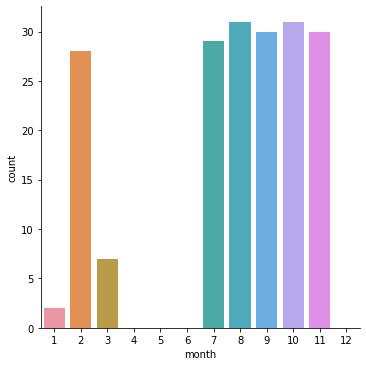

In [29]:
boxplot = sns.catplot(x = "month", kind = "count", order = [1,2,3,4,5,6,7,8,9,10,11,12], data = EDADF.loc[(EDADF['year'] == 2017) & (EDADF['redtide_pp'] == 1)])

### Presence of Red Tide in Puerto Princesa Bay 2018

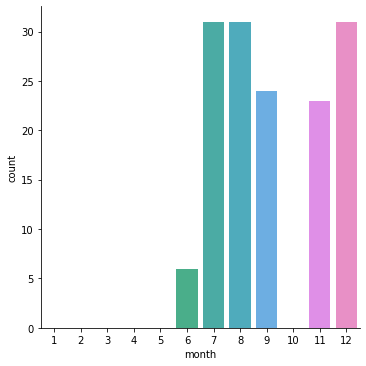

In [29]:
boxplot = sns.catplot(x = "month", kind = "count", order = [1,2,3,4,5,6,7,8,9,10,11,12], data = EDADF.loc[(EDADF['year'] == 2018) & (EDADF['redtide_pp'] ==1)])

### Presence of Red Tide in Puerto Princesa Bay 2019

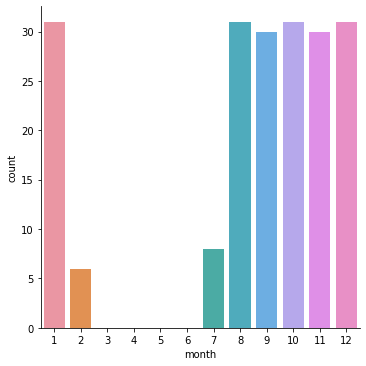

In [30]:
boxplot = sns.catplot(x = "month", kind = "count", order = [1,2,3,4,5,6,7,8,9,10,11,12], data = EDADF.loc[(EDADF['year'] == 2019) & (EDADF['redtide_pp'] ==1)])

### Presence of Red Tide in Puerto Princesa Bay 2020

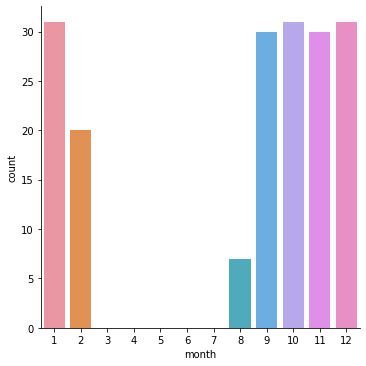

In [31]:
boxplot = sns.catplot(x = "month", kind = "count", order = [1,2,3,4,5,6,7,8,9,10,11,12], data = EDADF.loc[(EDADF['year'] == 2020) & (EDADF['redtide_pp'] ==1)])

### Presence of Red Tide in Honda Bay 2017

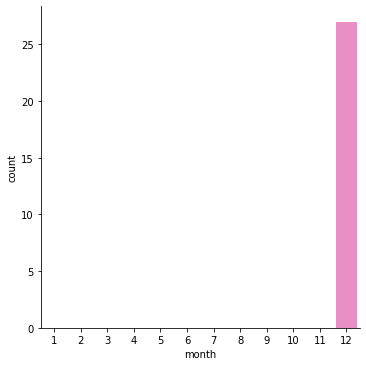

In [32]:
boxplot = sns.catplot(x = "month", kind = "count", order = [1,2,3,4,5,6,7,8,9,10,11,12], data = EDADF.loc[(EDADF['year'] == 2017) & (EDADF['redtide_honda'] ==1)])

### Presence of Red Tide in Honda Bay 2018

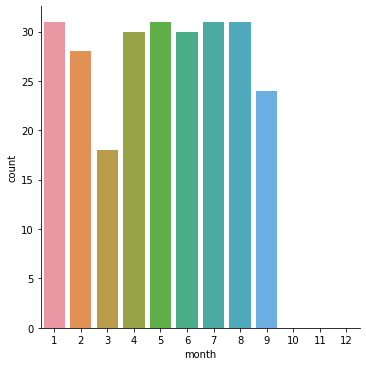

In [33]:
boxplot = sns.catplot(x = "month", kind = "count", order = [1,2,3,4,5,6,7,8,9,10,11,12], data = EDADF.loc[(EDADF['year'] == 2018) & (EDADF['redtide_honda'] ==1)])

### Presence of Red Tide in Honda Bay 2019

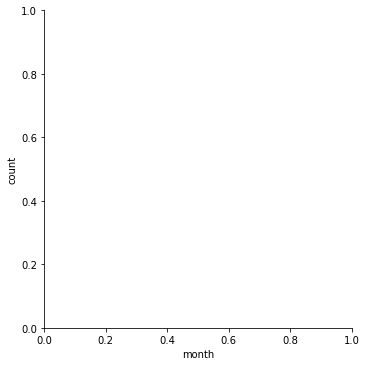

In [34]:
boxplot = sns.catplot(x = "month", kind = "count", order = [1,2,3,4,5,6,7,8,9,10,11,12], data = EDADF.loc[(EDADF['year'] == 2019) & (EDADF['redtide_honda'] ==1)])

### Presence of Red Tide in Honda Bay 2020

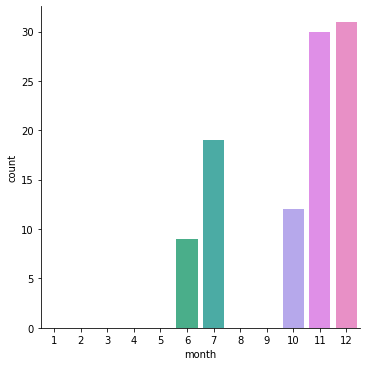

In [35]:
boxplot = sns.catplot(x = "month", kind = "count", order = [1,2,3,4,5,6,7,8,9,10,11,12], data = EDADF.loc[(EDADF['year'] == 2020) & (EDADF['redtide_honda'] ==1)])

## (Exploratory) On average, what are the highest and lowest height of tides in a month? 

In [36]:
EDATIDE = finalDF[["date", "tideheight1", "tideheight2", "tideheight3", "tideheight4", "month", "year"]]
EDATIDE.head(10)

,date,tideheight1,tideheight2,tideheight3,tideheight4,month,year
0,2017-01-01,-0.2,1.4,NaN,NaN,1,2017
1,2017-01-02,-0.2,NaN,NaN,NaN,1,2017
2,2017-01-03,1.3,-0.2,NaN,NaN,1,2017
3,2017-01-04,1.2,-0.1,NaN,NaN,1,2017
4,2017-01-05,1.1,0.0,0.7,0.4,1,2017
5,2017-01-06,1.0,0.0,0.8,0.4,1,2017
6,2017-01-07,0.8,0.1,1.0,0.0,1,2017
7,2017-01-08,0.2,0.6,0.2,1.1,1,2017
8,2017-01-09,0.1,0.6,0.2,1.3,1,2017
9,2017-01-10,-0.1,1.4,NaN,NaN,1,2017


In [39]:
EDATIDE = EDATIDE.melt(id_vars=["date", "month", "year"], value_vars=["tideheight1", "tideheight2", "tideheight3", "tideheight4"], var_name="tideheight")
EDATIDE.sort_values(by=['date'], inplace=True)
EDATIDE

,date,month,year,tideheight,value
0,2017-01-01,1,2017,tideheight1,-0.2
2922,2017-01-01,1,2017,tideheight3,NaN
4383,2017-01-01,1,2017,tideheight4,NaN
1461,2017-01-01,1,2017,tideheight2,1.4
1,2017-01-02,1,2017,tideheight1,-0.2
...,...,...,...,...,...
1459,2020-12-30,12,2020,tideheight1,-0.2
2921,2020-12-31,12,2020,tideheight2,1.5
1460,2020-12-31,12,2020,tideheight1,-0.3
4382,2020-12-31,12,2020,tideheight3,NaN


### Average Tide Height 2017

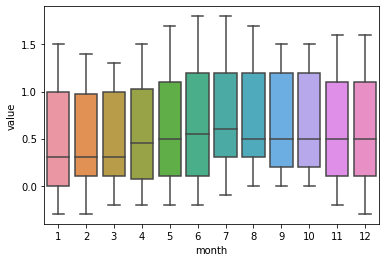

In [40]:
whisk = sns.boxplot(x = "month", y = 'value' , order = [1,2,3,4,5,6,7,8,9,10,11,12], data = EDATIDE.loc[(EDATIDE['value'] != 99999.0) & (EDATIDE['year'] == 2017)])

### Average Tide Height 2018

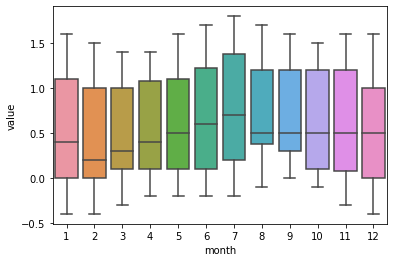

In [41]:
whisk = sns.boxplot(x = "month", y = 'value' , order = [1,2,3,4,5,6,7,8,9,10,11,12], data = EDATIDE.loc[(EDATIDE['value'] != 99999.0) & (EDATIDE['year'] == 2018)])

### Average Tide Height 2019

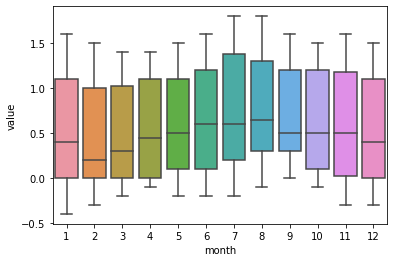

In [42]:
whisk = sns.boxplot(x = "month", y = 'value' , order = [1,2,3,4,5,6,7,8,9,10,11,12], data = EDATIDE.loc[(EDATIDE['value'] != 99999.0) & (EDATIDE['year'] == 2019)])

### Average Tide Height 2020

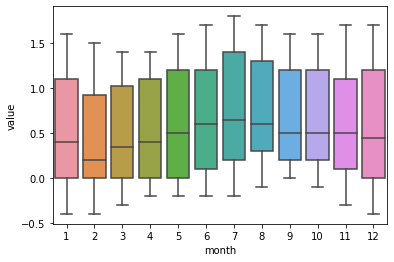

In [43]:
whisk = sns.boxplot(x = "month", y = 'value' , order = [1,2,3,4,5,6,7,8,9,10,11,12], data = EDATIDE.loc[(EDATIDE['value'] != 99999.0) & (EDATIDE['year'] == 2020)])

### Average Tide Height 2017-2020

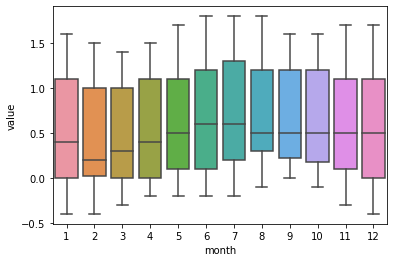

In [44]:
whisk = sns.boxplot(x = "month", y = 'value' , order = [1,2,3,4,5,6,7,8,9,10,11,12], data = EDATIDE.loc[(EDATIDE['value'] != 99999.0)])

## (Exploratory) On average, what times do low or high tides happen?

In [73]:
AverageLH = finalDF.copy()
Tides = AverageLH[['date','tidetime1','tidetype1', 'tidetime2','tidetype2','tidetime3','tidetype3','tidetime4','tidetype4']]

# for index, row in AveLH.iterrows():
#     if isinstance(row['tidetime1'], datetime.datetime):
#         toRep= row['tidetime1']
#         rep= row['tidetime1'].hour
#         print(toRep)
#         AveLH.replace({'tidetime1': {'2017-01-01 07:44:00' : rep}})
#         print(AverageLH['tidetime1'])
#         row['tidetime1']= row['tidetime1'].hour
#         AverageLH['tidetieprint(row['tidetime1'])

tidesarray1 = []
tidesarray2 = []
tidesarray3 = []
tidesarray4 = []

for index, row in Tides.iterrows():
    if isinstance(row['tidetime1'], datetime.datetime):
        row['tidetime1']= row['tidetime1'].hour
        tidesarray1.append(row['tidetime1'])
        
    if isinstance(row['tidetime2'], datetime.datetime):
        row['tidetime2']= row['tidetime2'].hour
        tidesarray2.append(row['tidetime2'])
    else:
        tidesarray2.append(9999)
        
    if isinstance(row['tidetime3'], datetime.datetime):
        row['tidetime3']= row['tidetime3'].hour
        tidesarray3.append(row['tidetime3'])
    else:
        tidesarray3.append(9999)
        
    if isinstance(row['tidetime4'], datetime.datetime):
        row['tidetime4']= row['tidetime4'].hour
        tidesarray4.append(row['tidetime4'])
    else:
        tidesarray4.append(9999)
        
#Tides array
Tides['tidetime1']=tidesarray1
Tides['tidetime2']=tidesarray2
Tides['tidetime3']=tidesarray3
Tides['tidetime4']=tidesarray4
Tides

<ipython-input-73-6553313b1e84>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tides['tidetime1']=tidesarray1
<ipython-input-73-6553313b1e84>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tides['tidetime2']=tidesarray2
<ipython-input-73-6553313b1e84>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

,date,tidetime1,tidetype1,tidetime2,tidetype2,tidetime3,tidetype3,tidetime4,tidetype4
0,2017-01-01,7,-1,23.0,1,NaN,0,NaN,0
1,2017-01-02,8,-1,NaN,0,NaN,0,NaN,0
2,2017-01-03,0,1,8.0,-1,NaN,0,NaN,0
3,2017-01-04,0,1,9.0,-1,NaN,0,NaN,0
4,2017-01-05,1,1,9.0,-1,17.0,1,20.0,-1
...,...,...,...,...,...,...,...,...,...
1456,2020-12-27,3,-1,10.0,1,12.0,-1,20.0,1
1457,2020-12-28,4,-1,20.0,1,NaN,0,NaN,0
1458,2020-12-29,5,-1,21.0,1,NaN,0,NaN,0
1459,2020-12-30,5,-1,21.0,1,NaN,0,NaN,0


In [74]:
AverageLH = Tides.rename(columns={"date":"Month"})

In [75]:
tideA = AverageLH.copy()
tideA

,Month,tidetime1,tidetype1,tidetime2,tidetype2,tidetime3,tidetype3,tidetime4,tidetype4
0,2017-01-01,7,-1,23.0,1,NaN,0,NaN,0
1,2017-01-02,8,-1,NaN,0,NaN,0,NaN,0
2,2017-01-03,0,1,8.0,-1,NaN,0,NaN,0
3,2017-01-04,0,1,9.0,-1,NaN,0,NaN,0
4,2017-01-05,1,1,9.0,-1,17.0,1,20.0,-1
...,...,...,...,...,...,...,...,...,...
1456,2020-12-27,3,-1,10.0,1,12.0,-1,20.0,1
1457,2020-12-28,4,-1,20.0,1,NaN,0,NaN,0
1458,2020-12-29,5,-1,21.0,1,NaN,0,NaN,0
1459,2020-12-30,5,-1,21.0,1,NaN,0,NaN,0


In [76]:
#For high tides
hightype1 = []
hightype2 = []
hightype3 = []
hightype4 = []

hightime2 = []
hightime3 = []
hightime4 = []

for index, row in tideA.iterrows():
    if row['tidetype1'] == -1 or row['tidetype1'] == 0:
        change = 0
        hightype1.append(0)
    elif row['tidetype1'] == 1:
        hightype1.append(1)
    
for index, row in tideA.iterrows():
    if row['tidetype2'] == -1 or row['tidetype2'] == 0:
        hightype2.append(0)
    elif row['tidetype2'] == 1:
        hightype2.append(1)

    if pd.isna(row['tidetime2']):
        hightime2.append(0)
    else:
        hightime2.append(row['tidetime2'])

for index, row in tideA.iterrows():
    if row['tidetype3'] == -1 or row['tidetype3'] == 0:
        hightype3.append(0)
    elif row['tidetype3'] == 1:
        hightype3.append(1)
    
    if pd.isna(row['tidetime3']):
        hightime3.append(0)
    else:
        hightime3.append(row['tidetime3'])
        
for index, row in tideA.iterrows():
    if row['tidetype4'] == -1 or row['tidetype4'] == 0:
        hightype4.append(0)
    elif row['tidetype4'] == 1:
        hightype4.append(1)
    else:
#         print(row['tidetype4'])
        hightype4.append(0)
        
    if pd.isna(row['tidetime4']):
        hightime4.append(0)
    else:
        hightime4.append(row['tidetime4'])


#Assign High    
tideA['tidetype1'] = hightype1
tideA['tidetype2'] = hightype2
tideA['tidetype3'] = hightype3
tideA['tidetype4'] = hightype4

tideA['tidetime2'] = hightime2
tideA['tidetime3'] = hightime3
tideA['tidetime4'] = hightime4

tide1 = tideA[['Month','tidetime1','tidetype1']]
tide2 = tideA[['Month', 'tidetime2','tidetype2']]
tide3 = tideA[['Month', 'tidetime3','tidetype3']]
tide4 = tideA[['Month', 'tidetime4','tidetype4']]

In [77]:
tideB = AverageLH.copy()
tideB = tideB.rename(columns={"tidetype1":"lowtidetype1", "tidetime1":"lowtidetime1","tidetype2":"lowtidetype2", "tidetime2":"lowtidetime2",
                              "tidetype3":"lowtidetype3", "tidetime3":"lowtidetime3","tidetype4":"lowtidetype4", "tidetime4":"lowtidetime4"})
tideB

,Month,lowtidetime1,lowtidetype1,lowtidetime2,lowtidetype2,lowtidetime3,lowtidetype3,lowtidetime4,lowtidetype4
0,2017-01-01,7,-1,23.0,1,NaN,0,NaN,0
1,2017-01-02,8,-1,NaN,0,NaN,0,NaN,0
2,2017-01-03,0,1,8.0,-1,NaN,0,NaN,0
3,2017-01-04,0,1,9.0,-1,NaN,0,NaN,0
4,2017-01-05,1,1,9.0,-1,17.0,1,20.0,-1
...,...,...,...,...,...,...,...,...,...
1456,2020-12-27,3,-1,10.0,1,12.0,-1,20.0,1
1457,2020-12-28,4,-1,20.0,1,NaN,0,NaN,0
1458,2020-12-29,5,-1,21.0,1,NaN,0,NaN,0
1459,2020-12-30,5,-1,21.0,1,NaN,0,NaN,0


In [78]:
#For low tides
lowtype1 = []
lowtype2 = []
lowtype3 = []
lowtype4 = []

lowtime2 = []
lowtime3 = []
lowtime4 = []

for index, row in tideB.iterrows():
    if row['lowtidetype1'] == 1 or row['lowtidetype1'] == 0:
        lowtype1.append(0)
    elif row['lowtidetype1'] == -1:
        lowtype1.append(1)
    
for index, row in tideB.iterrows():
    if row['lowtidetype2'] == 1 or row['lowtidetype2'] == 0:
        lowtype2.append(0)
    elif row['lowtidetype2'] == -1:
        lowtype2.append(1)
    
    if pd.isna(row['lowtidetime2']):
        lowtime2.append(0)
    else:
        lowtime2.append(row['lowtidetime2'])

        
for index, row in tideB.iterrows():
    if row['lowtidetype3'] == 1 or row['lowtidetype3'] == 0:
        lowtype3.append(0)
    elif row['lowtidetype3'] == -1:
        lowtype3.append(1)
    
    if pd.isna(row['lowtidetime3']):
        lowtime3.append(0)
    else:
        lowtime3.append(row['lowtidetime3'])
        
for index, row in tideB.iterrows():
    if row['lowtidetype4'] == 1 or row['lowtidetype4'] == 0:
        lowtype4.append(0)
    elif row['lowtidetype4'] == -1:
        lowtype4.append(1)
    else:
#         print(row['lowtidetype4'])
        lowtype4.append(0)
        
    if pd.isna(row['lowtidetime4']):
        lowtime4.append(0)
    else:
        lowtime4.append(row['lowtidetime4'])

#Assign low
tideB['lowtidetype1'] = lowtype1
tideB['lowtidetype2'] = lowtype2
tideB['lowtidetype3'] = lowtype3
tideB['lowtidetype4'] = lowtype4

#print(tideB['lowtidetype1'])
#print(lowtype1)
tideB['lowtidetime2'] = lowtime2
tideB['lowtidetime3'] = lowtime3
tideB['lowtidetime4'] = lowtime4


Ltide1 = tideB[['Month','lowtidetime1','lowtidetype1']]
Ltide2 = tideB[['Month','lowtidetime2','lowtidetype2']]
Ltide3 = tideB[['Month','lowtidetime3','lowtidetype3']]
Ltide4 = tideB[['Month','lowtidetime4','lowtidetype4']]

In [79]:
#For High
tide1matrix = pd.pivot_table(tide1, index='Month', columns='tidetime1', values='tidetype1', aggfunc=np.sum, fill_value=0)
tide2matrix = pd.pivot_table(tide2, index='Month', columns='tidetime2', values='tidetype2', aggfunc=np.sum, fill_value=0)
tide3matrix = pd.pivot_table(tide3, index='Month', columns='tidetime3', values='tidetype3', aggfunc=np.sum, fill_value=0)
tide4matrix = pd.pivot_table(tide4, index='Month', columns='tidetime4', values='tidetype4', aggfunc=np.sum, fill_value=0)

#For Low
Ltide1matrix = pd.pivot_table(Ltide1, index='Month', columns='lowtidetime1', values='lowtidetype1', aggfunc=np.sum, fill_value=0)
Ltide2matrix = pd.pivot_table(Ltide2, index='Month', columns='lowtidetime2', values='lowtidetype2', aggfunc=np.sum, fill_value=0)
Ltide3matrix = pd.pivot_table(Ltide3, index='Month', columns='lowtidetime3', values='lowtidetype3', aggfunc=np.sum, fill_value=0)
Ltide4matrix = pd.pivot_table(Ltide4, index='Month', columns='lowtidetime4', values='lowtidetype4', aggfunc=np.sum, fill_value=0)
#c=pd.concat([tide1matrix, tide2matrix], axis = 1)
#tide1matrix
add=[0,0,0,0,0,0,0,0,0,0,0,0]

#For HTIDE
tide1matrix.insert(17, "17", add)
tide1matrix.insert(18, "18", add)
tide1matrix.insert(19, "19", add)
tide1matrix.insert(20, "20", add)
tide1matrix.insert(21, "21", add)
tide1matrix.insert(22, "22", add)
tide1matrix.insert(23, "23", add)

tide3matrix.insert(1,"1.0",add)
tide3matrix.insert(2,"2.0",add)
tide3matrix.insert(3,"3.0",add)
tide3matrix.insert(4,"4.0",add)
tide3matrix.insert(5,"5.0",add)
tide3matrix.insert(6,"6.0",add)
tide3matrix.insert(7,"7.0",add)

tide4matrix.insert(1,"1.0",add)
tide4matrix.insert(2,"2.0",add)
tide4matrix.insert(3,"3.0",add)
tide4matrix.insert(4,"4.0",add)
tide4matrix.insert(5,"5.0",add)
tide4matrix.insert(6,"6.0",add)
tide4matrix.insert(7,"7.0",add)
tide4matrix.insert(8,"8.0",add)
tide4matrix.insert(9,"9.0",add)
tide4matrix.insert(10,"10.0",add)
tide4matrix.insert(11,"11.0",add)
tide4matrix.insert(12,"12.0",add)
tide4matrix.insert(13,"13.0",add)
tide4matrix.insert(14,"14.0",add)
tide4matrix.insert(15,"15.0",add)

firstadd = np.add(tide1matrix,tide2matrix)
secondadd = np.add(firstadd, tide3matrix)
finalhighmatrix = np.add(secondadd,tide4matrix)

#For LTIDE

ValueError: Length of values (12) does not match length of index (1461)

In [80]:
Ltide1matrix.insert(17, "17", add)
Ltide1matrix.insert(18, "18", add)
Ltide1matrix.insert(19, "19", add)
Ltide1matrix.insert(20, "20", add)
Ltide1matrix.insert(21, "21", add)
Ltide1matrix.insert(22, "22", add)
Ltide1matrix.insert(23, "23", add)

ValueError: Length of values (12) does not match length of index (1461)

In [81]:
Ltide3matrix.insert(1,"1.0",add)
Ltide3matrix.insert(2,"2.0",add)
Ltide3matrix.insert(3,"3.0",add)
Ltide3matrix.insert(4,"4.0",add)
Ltide3matrix.insert(5,"5.0",add)
Ltide3matrix.insert(6,"6.0",add)
Ltide3matrix.insert(7,"7.0",add)

ValueError: Length of values (12) does not match length of index (1461)

In [503]:
Ltide4matrix.insert(1,"1.0",add)
Ltide4matrix.insert(2,"2.0",add)
Ltide4matrix.insert(3,"3.0",add)
Ltide4matrix.insert(4,"4.0",add)
Ltide4matrix.insert(5,"5.0",add)
Ltide4matrix.insert(6,"6.0",add)
Ltide4matrix.insert(7,"7.0",add)
Ltide4matrix.insert(8,"8.0",add)
Ltide4matrix.insert(9,"9.0",add)
Ltide4matrix.insert(10,"10.0",add)
Ltide4matrix.insert(11,"11.0",add)
Ltide4matrix.insert(12,"12.0",add)
Ltide4matrix.insert(13,"13.0",add)
Ltide4matrix.insert(14,"14.0",add)
Ltide4matrix.insert(15,"15.0",add)

Lfirstadd = np.add(Ltide1matrix,Ltide2matrix)
Lsecondadd = np.add(Lfirstadd, Ltide3matrix)
finallowmatrix = np.add(Lsecondadd,Ltide4matrix)
finallowmatrix

<ipython-input-503-d6f29943a5a8>:17: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  Lfirstadd= np.add(Ltide1matrix,Ltide2matrix)
<ipython-input-503-d6f29943a5a8>:18: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep th

lowtidetime1,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Month,,,,,,,,,,,,,,,,,,,,,
1,3,6,6,10,14,9,14,15,15,22,...,1,5,3,4,3,5,2,5,3,4
2,3,6,5,11,10,13,14,25,22,7,...,5,8,8,7,6,6,5,6,3,5
3,3,6,11,9,19,21,29,13,0,0,...,8,10,8,9,8,8,8,5,6,7
4,8,9,11,19,28,19,2,0,0,0,...,5,9,9,10,9,9,9,6,6,6
5,11,15,28,19,4,0,0,0,0,0,...,9,9,9,9,12,9,8,10,9,10
6,24,13,5,0,0,0,1,0,1,3,...,3,9,12,10,12,10,11,11,13,16
7,2,0,1,2,1,2,3,5,3,4,...,8,10,11,14,11,15,14,20,21,10
8,1,1,7,9,8,9,7,5,6,4,...,8,9,16,13,17,22,24,10,0,0
9,4,7,6,10,8,8,8,7,7,7,...,10,9,17,22,28,11,0,0,0,1


### Heat Map for High Tides

NameError: name 'finalhighmatrix' is not defined

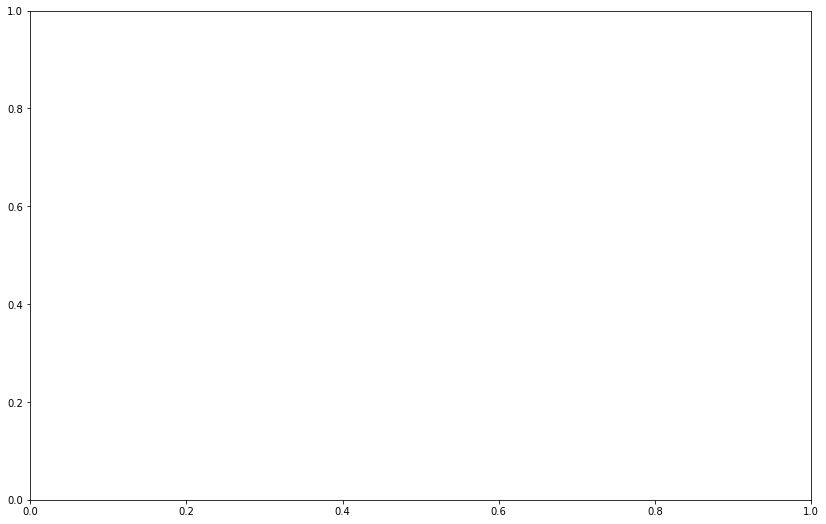

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14,9))
Htideheatmap = sns.heatmap(finalhighmatrix, cmap="YlGnBu", annot=True, fmt="d", annot_kws={"size": 10}, ax=ax)

#tide1heatmap

### Heat Map for Low Tides

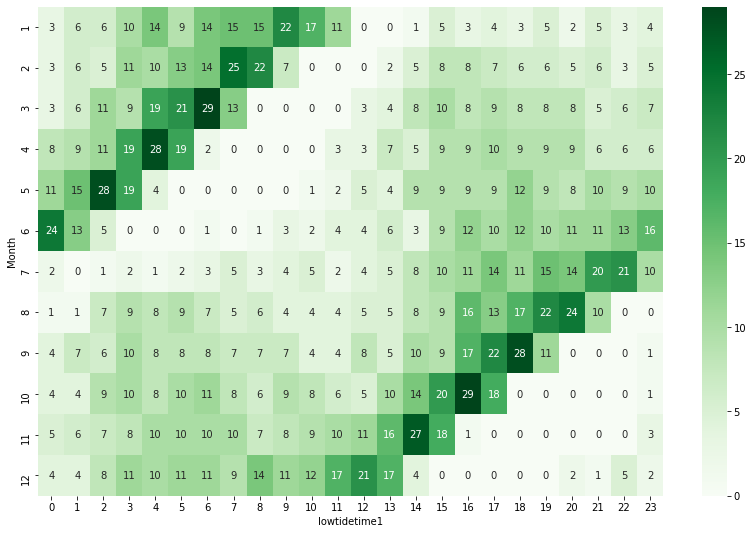

In [507]:
fig, ax = plt.subplots(figsize=(14,9))
Ltideheatmap = sns.heatmap(finallowmatrix, cmap="Greens",annot=True, fmt="d", annot_kws={"size": 10}, ax=ax)


## (Exploratory) Is there a pattern in the event of a red tide?

In [39]:
#Creating a dataframe for selected variables 
rtDF = finalDF[["date", "redtide_pp", "redtide_honda"]]
rtDF["month"] = pd.DatetimeIndex(rtDF["date"]).month
rtDF

<ipython-input-39-1e74baba1fd3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rtDF["month"] = pd.DatetimeIndex(rtDF["date"]).month


,date,redtide_pp,redtide_honda,month
0,2017-01-01,0,0,1
1,2017-01-02,0,0,1
2,2017-01-03,0,0,1
3,2017-01-04,0,0,1
4,2017-01-05,0,0,1
...,...,...,...,...
1456,2020-12-27,1,1,12
1457,2020-12-28,1,1,12
1458,2020-12-29,1,1,12
1459,2020-12-30,1,1,12


In [52]:
#Grouping the red tide occurrences in Puerto Princesa Bay by month from 2017-2020
total_rtpp_monthly = rtDF.groupby(["month"], as_index=False)["redtide_pp"].sum()
total_rtpp_monthly = total_rtpp_monthly.rename(columns={"month": "Month", "redtide_pp": "Red Tide Occurrences"}, errors="raise")
total_rtpp_monthly

,Month,Red Tide Occurrences
0,1,64
1,2,54
2,3,7
3,4,0
4,5,0
5,6,6
6,7,68
7,8,100
8,9,114
9,10,93


### Bar Graph on Red Tide Occurrences in Puerto Princesa Bay

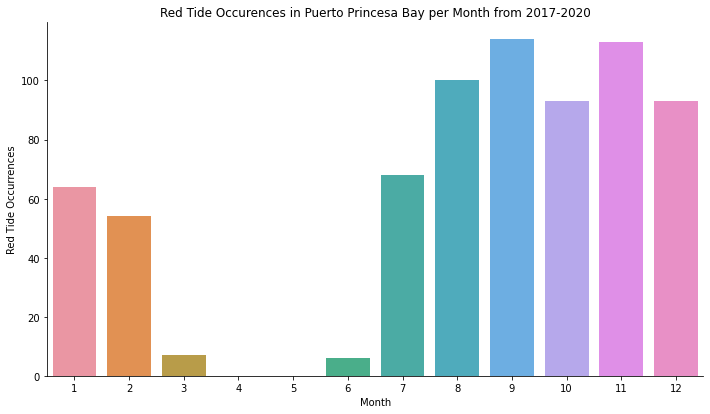

In [55]:
# Creating a bar graph on the red tide occurrences in Puerto Princesa Bay
total_annual_plot_pp = sns.catplot(data=total_rtpp_monthly, kind="bar", x="Month", y="Red Tide Occurrences").set(title='Red Tide Occurences in Puerto Princesa Bay per Month from 2017-2020')
total_annual_plot_pp.set_axis_labels("Month", "Red Tide Occurrences")
total_annual_plot_pp.fig.set_size_inches(10.5, 5.5)

### Calendar Heat Map on Red Tide Occurrences in Puerto Princesa Bay

(<Figure size 720x489.6 with 4 Axes>,
 array([<AxesSubplot:ylabel='2017'>, <AxesSubplot:ylabel='2018'>,
        <AxesSubplot:ylabel='2019'>, <AxesSubplot:ylabel='2020'>],
       dtype=object))

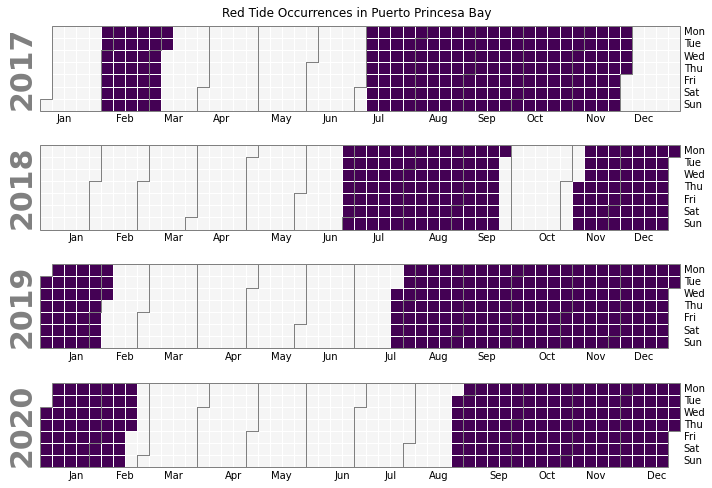

In [58]:
# Creating a calendar heat map on the red tide occurrences in Puerto Princesa Bay
data_pp = finalDF[["date", "redtide_pp"]] 
data_pp = data_pp.set_index("date")

calplot.calplot(data_pp["redtide_pp"], suptitle="Red Tide Occurrences in Puerto Princesa Bay", colorbar=False)

As per the bar graph and calendar heatmap above, it could be said that the red tide occurrences in Puerto Princesa Bay often occur during the early months and the second half of the year. 

In [53]:
#Grouping the red tide occurrences in Honda Bay by month from 2017-2020
total_rthonda_monthly = rtDF.groupby(["month"], as_index=False)["redtide_honda"].sum()
total_rthonda_monthly = total_rthonda_monthly.rename(columns={"month": "Month", "redtide_honda": "Red Tide Occurrence"}, errors="raise")
total_rthonda_monthly

,Month,Red Tide Occurrences
0,1,31
1,2,28
2,3,18
3,4,30
4,5,31
5,6,39
6,7,50
7,8,31
8,9,24
9,10,12


### Bar Graph on Red Tide Occurrences in Honda Bay

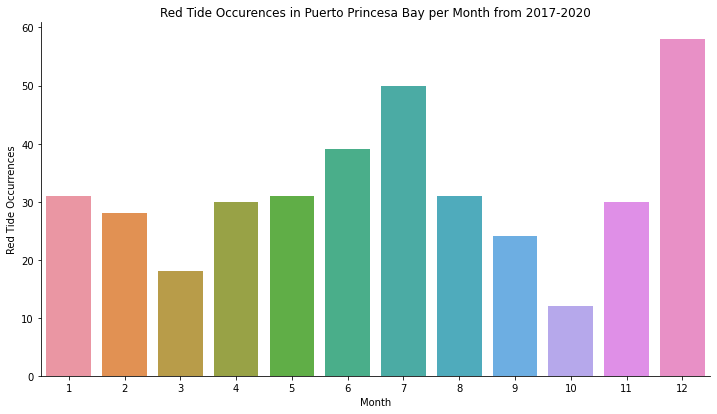

In [57]:
# Creating a bar graph on the red tide occurrences in Honda Bay
total_annual_plot_honda = sns.catplot(data=total_rthonda_monthly, kind="bar", x="Month", y="Red Tide Occurrences").set(title='Red Tide Occurences in Puerto Princesa Bay per Month from 2017-2020')
total_annual_plot_honda.set_axis_labels("Month", "Red Tide Occurrences")
total_annual_plot_honda.fig.set_size_inches(10.5, 5.5)

### Calendar Heat Map on Red Tide Occurrences in Honda Bay

(<Figure size 720x489.6 with 4 Axes>,
 array([<AxesSubplot:ylabel='2017'>, <AxesSubplot:ylabel='2018'>,
        <AxesSubplot:ylabel='2019'>, <AxesSubplot:ylabel='2020'>],
       dtype=object))

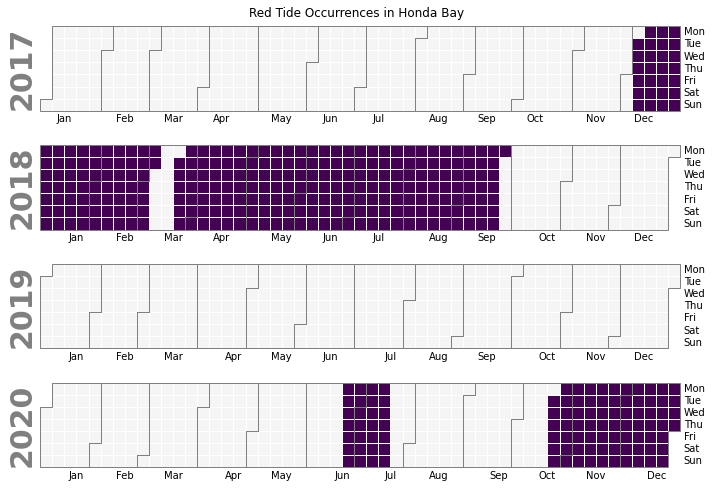

In [62]:
# Creating a calendar heatmap on the red tide occurrences in Honda Bay
data_honda = finalDF[["date", "redtide_honda"]] 
data_honda = data_honda.set_index("date")

calplot.calplot(data_honda["redtide_honda"], suptitle="Red Tide Occurrences in Honda Bay", colorbar=False)

Based on the bar graph and calendar heatmap, the red tide occurrences in Honda Bay has no pattern. It is notable though that in 2019, there was no reported red tide. Compared to the occurrences in Puerto Princesa Bay, the occurrences here are less frequent.

# Scratch Code

Test scrape for one month for Tide Information.

Test scrape for one month for Moonrise and Moonset.

In [112]:
import pandas as pd

df = pd.DataFrame({'c1': [10, 11, 12], 'c2': [100, 110, 120]})

for index, row in df.iterrows():
    row['c1']="x"
    print(row['c1'])

x
x
x


In [169]:
import numpy as np
x=[]

x.append("asda")

print(x)

['asda']
